# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from sklearn.metrics import f1_score

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [6]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

filename = str(data_path + 'all_sequences_09-29-2025')
filename = str(data_path + 'all_sequences_02-12-2026')
all_sequences = pd.read_parquet(filename)


metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/mixed_models/metadata_13-01-2026')
# metadata = pd.read_parquet(prefix + 'representation_learning_variability/paper-individuality/mixed_models/metadata_01-11-2026')

In [8]:
data_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
# cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice_pop_norm_3Feb2026')
cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice_lab_norm_30Jan2026')
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')
# cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice_no_norm_4Feb2026')

cluster_df = cluster_df.rename(columns={'cluster':'mouse_cluster'})


In [9]:
## Get sequences per trial epoch
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()

In [10]:
mice = design_df.mouse_name.unique()
dob = pd.DataFrame(columns=['mouse_name', 'dob'], index=range(len(mice)))
for s, mouse in enumerate(mice):
    subject_info = one.alyx.rest('subjects', 'read', id=mouse)
    date_of_birth = subject_info.get('birth_date')
    dob['mouse_name'][s] = mouse
    dob['dob'][s] = date_of_birth

/tmp/ipykernel_47741/3358271333.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dob['mouse_name'][s] = mouse
/tmp/ipykernel_47741/3358271333.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are settin

## Get sequences per trial

In [11]:
all_sequences['session'] = all_sequences['sample'].str[:36]
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [12]:
session_count = design_df[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>2, 'mouse_name']
design_df = design_df.loc[design_df['mouse_name'].isin(multi_sess_mice)]

In [13]:
len(multi_sess_mice)

39

In [14]:
design_df = design_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name')

## Separate states per variable (one-hot encoding)

In [15]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
# use_sequences = replace_func(use_sequences)

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

## Average per session

In [16]:
session_syllables = pd.DataFrame(binarized)
session_syllables['session'] = design_df['session'].copy()
session_syllables = session_syllables.groupby('session')[np.arange(0, np.shape(binarized)[1], 1)].mean()

In [17]:
mapping = design_df[['mouse_name', 'session', 'mouse_cluster']].drop_duplicates()

Text(0, 0.5, 'Sessions')

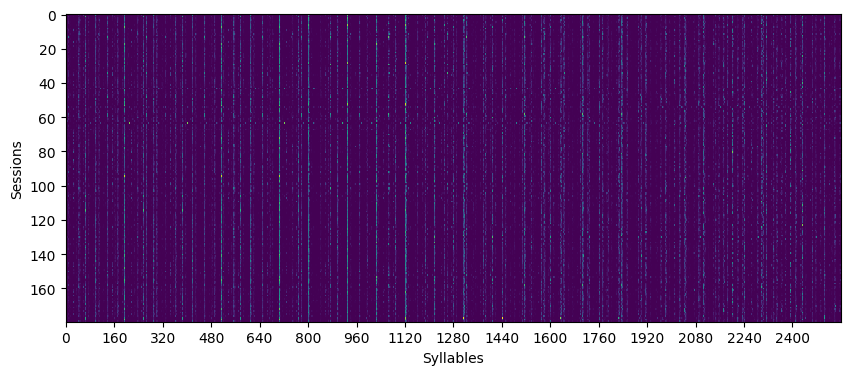

In [18]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.xlabel('Syllables')
plt.ylabel('Sessions')

Text(0.5, 1.0, 'Explained Variance by PCA')

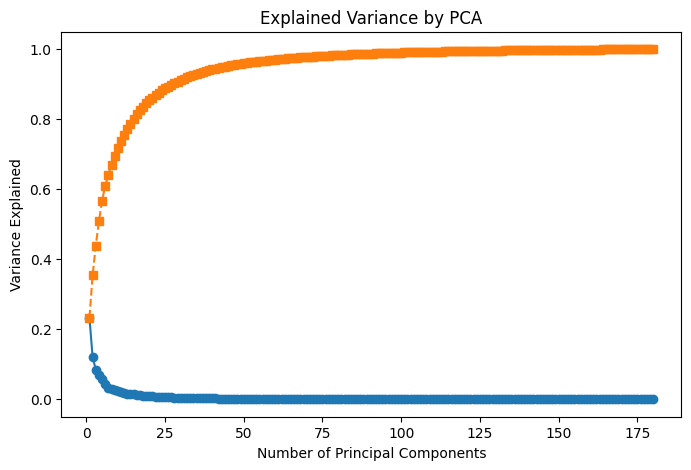

In [19]:
# PCA
n_components = np.shape(np.array(session_syllables))[0]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
# standardized_X = scaler.fit_transform(np.array(session_syllables))
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(np.array(session_syllables))

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [20]:
min_components = np.where(cumulative_variance>0.95)[0][0]
print(min_components)
min_components = 20

43


Text(0, 0.5, 'Sessions')

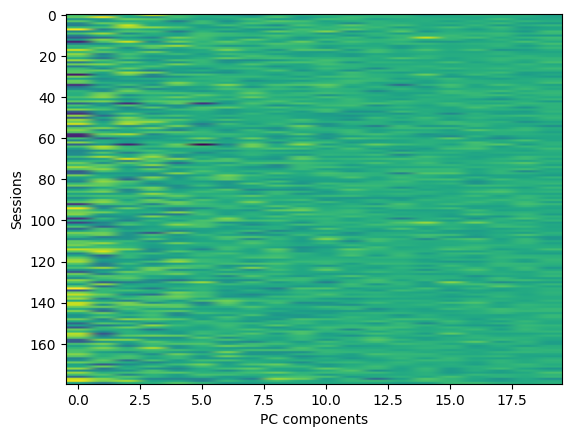

In [21]:
plt.imshow(X_pca[:, :min_components], aspect='auto')
plt.xlabel('PC components')
plt.ylabel('Sessions')

# Normalize per lab

In [22]:
mat = np.array(session_syllables.copy())
mat = np.array(X_pca[:, :min_components])

# session_syllables['session'] = data['session']
lab_df = session_syllables.reset_index().merge(metadata, on='session', how='left')
norm_array = np.ones((np.shape(mat))) * np.nan

scaler = StandardScaler()
norm_pop = scaler.fit_transform(mat.copy())
    
labs = np.unique(lab_df['lab'])
labs_array = np.array(lab_df['lab']).copy()
# np.random.shuffle(labs_array)
for i, lab in enumerate(labs):
    lab_idx = np.where(labs_array==lab)[0]
    lab_data = mat[lab_idx, :]

    scaler = StandardScaler()
    scaled = scaler.fit_transform(lab_data.copy())
    norm_array[lab_idx, :] = scaled.copy()

Text(0, 0.5, 'Sessions')

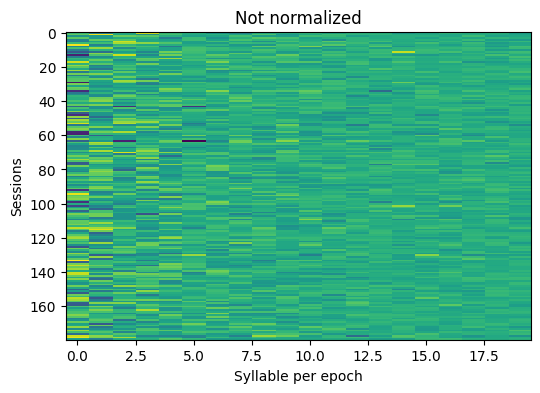

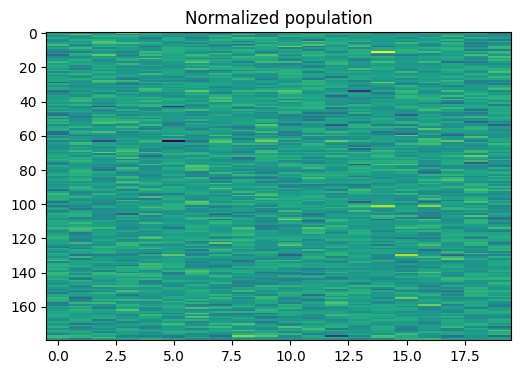

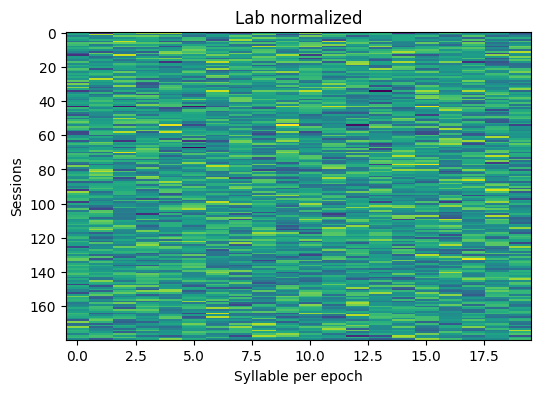

In [23]:
plt.figure(figsize=(6, 4))
plt.imshow(np.array(mat), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Not normalized')
plt.xlabel('Syllable per epoch')
plt.ylabel('Sessions')

plt.figure(figsize=(6, 4))
plt.imshow(np.array(norm_pop), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Normalized population')

plt.figure(figsize=(6, 4))
plt.imshow(np.array(norm_array), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(binarized)[1], 160), np.arange(0, np.shape(binarized)[1], 160))
plt.title('Lab normalized')
plt.xlabel('Syllable per epoch')
plt.ylabel('Sessions')


# LDA

## Leave-one-session-out CV

In [24]:
mouse_names = session_syllables.reset_index().merge(mapping, on=['session'])['mouse_name']
lab_id = session_syllables.reset_index().merge(metadata, on=['session'])['lab']
df = session_syllables.reset_index().merge(mapping, on=['session'])
dob_df = df.merge(dob, on='mouse_name')
litter_id = dob_df['dob']

In [25]:
n_per_mouse = 3
lda_components = 30
lda_components = min_components
n_repeats = 100

final_matrix = np.array(norm_array)
final_matrix = np.array(norm_pop)
# final_matrix = np.array(mat)

X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]

n_samples = X.shape[0]

rng = np.random.default_rng(0)

# Store repeat results
true_scores_all = []
shuffle_scores_all = []

for repeat in range(n_repeats):

    scores_true = []
    scores_shuff = []

    # Subsample balanced sessions for training in each fold
    for test_idx in range(n_samples):

        X_test = X[test_idx:test_idx+1]
        y_test = y[test_idx:test_idx+1]

        train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
        X_train_full = X[train_idx]
        y_train_full = y[train_idx]

        # --- balanced subsampling for training ---
        balanced_idx = []
        for m in np.unique(y_train_full):
            m_idx = np.where(y_train_full == m)[0]
            if len(m_idx) >= n_per_mouse-1:
                balanced_idx.extend(rng.choice(m_idx, n_per_mouse-1, replace=False))
            else:
                print(m)

        balanced_idx = np.array(balanced_idx)
        X_train = X_train_full[balanced_idx]
        y_train = y_train_full[balanced_idx]

        # --- true labels run ---
        lda = LinearDiscriminantAnalysis(
            priors=np.ones(len(np.unique(y_train))) / len(np.unique(y_train)),
            n_components=lda_components)
        lda.fit(X_train, y_train)
        scores_true.append(lda.score(X_test, y_test))

        # --- shuffled labels run ---
        y_train_shuff = y_train.copy()
        rng.shuffle(y_train_shuff)
        lda_shuff = LinearDiscriminantAnalysis(
            priors=np.ones(len(np.unique(y_train_shuff))) / len(np.unique(y_train_shuff)),
            n_components=lda_components)
        lda_shuff.fit(X_train, y_train_shuff)
        scores_shuff.append(lda_shuff.score(X_test, y_test))
        
    # store average score for this repeat
    true_scores_all.append(np.mean(scores_true))
    shuffle_scores_all.append(np.mean(scores_shuff))

print("True labels mean ± std:", np.mean(true_scores_all), np.std(true_scores_all))
print("Shuffled labels mean ± std:", np.mean(shuffle_scores_all), np.std(shuffle_scores_all))


True labels mean ± std: 0.674888888888889 0.028550150807151807
Shuffled labels mean ± std: 0.025888888888888885 0.01015983376941878


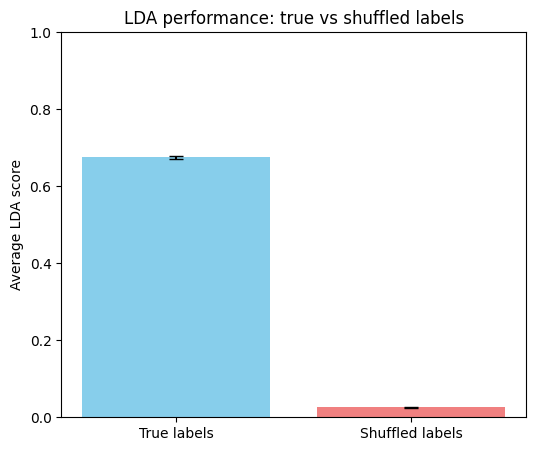

In [26]:
# Convert to arrays for convenience
true_scores = np.array(true_scores_all)
shuffle_scores = np.array(shuffle_scores_all)

# Compute means and standard deviations
means = [np.mean(true_scores), np.mean(shuffle_scores)]
stds  = [np.std(true_scores), np.std(shuffle_scores)]
std_errs = [np.std(true_scores)/np.sqrt(len(true_scores)), 
            np.std(shuffle_scores)/np.sqrt(len(shuffle_scores))]

labels = ['True labels', 'Shuffled labels']

# Create bar plot with error bars
plt.figure(figsize=(6,5))
plt.bar(labels, means, yerr=std_errs, capsize=5, color=['skyblue','lightcoral'])
plt.ylabel('Average LDA score')
plt.title('LDA performance: true vs shuffled labels')
plt.ylim(0,1)
plt.show()


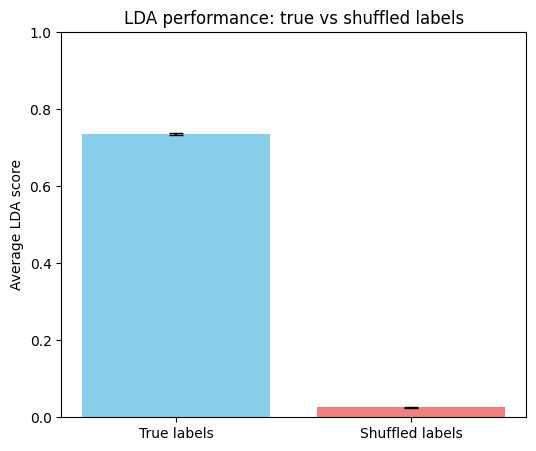

In [24]:
# Convert to arrays for convenience
true_scores = np.array(true_scores_all)
shuffle_scores = np.array(shuffle_scores_all)

# Compute means and standard deviations
means = [np.mean(true_scores), np.mean(shuffle_scores)]
stds  = [np.std(true_scores), np.std(shuffle_scores)]
std_errs = [np.std(true_scores)/np.sqrt(len(true_scores)), 
            np.std(shuffle_scores)/np.sqrt(len(shuffle_scores))]

labels = ['True labels', 'Shuffled labels']

# Create bar plot with error bars
plt.figure(figsize=(6,5))
plt.bar(labels, means, yerr=std_errs, capsize=5, color=['skyblue','lightcoral'])
plt.ylabel('Average LDA score')
plt.title('LDA performance: true vs shuffled labels')
plt.ylim(0,1)
plt.show()


In [27]:
n_per_mouse = 3
lda_components = 30
lda_components = min_components

final_matrix = np.array(norm_array)
final_matrix = np.array(norm_pop)
# final_matrix = np.array(mat)

X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]
n_samples = X.shape[0]
rng = np.random.default_rng(0)

# Subsample balanced sessions for training in each fold
for test_idx in range(n_samples):

    X_test = X[test_idx:test_idx+1]
    y_test = y[test_idx:test_idx+1]

    train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
    X_train_full = X[train_idx]
    y_train_full = y[train_idx]

    # --- balanced subsampling for training ---
    balanced_idx = []
    for m in np.unique(y_train_full):
        m_idx = np.where(y_train_full == m)[0]
        if len(m_idx) >= n_per_mouse:
            balanced_idx.extend(rng.choice(m_idx, n_per_mouse, replace=False))
        # else:
        #     # print(m)

    balanced_idx = np.array(balanced_idx)
    X_train = X_train_full[balanced_idx]
    y_train = y_train_full[balanced_idx]

In [28]:
# --- fit LDA ---
lda = LinearDiscriminantAnalysis(priors=np.ones(len(np.unique(y_train))) / 
                                    len(np.unique(y_train)), n_components=lda_components)

lda.fit(X_train, y_train)
# lda.fit(X_train_full, y_train_full)

# final_matrix = np.array(norm_array[:, :np.shape(X_train)[1]])
# X = final_matrix.copy()

final_transformed = lda.transform(X)
clustered = pd.DataFrame(final_transformed)
clustered['mouse_name'] = mouse_names
clustered['mouse_number'] = pd.factorize(clustered['mouse_name'])[0]
clustered['lab'] = lab_id
clustered['lab_number'] = pd.factorize(clustered['lab'])[0]
clustered['litter_id'] = litter_id
clustered['litter_number'] = pd.factorize(clustered['litter_id'])[0]

clustered = clustered.merge(cluster_df[['mouse_name', 'mouse_cluster']].drop_duplicates(), on=['mouse_name'])

In [29]:
from scipy.spatial import ConvexHull
import itertools

n_archetypes = 3

data_2d = final_transformed[:, :n_archetypes-1]

# 3. Convex hull
hull = ConvexHull(data_2d)
hull_points = data_2d[hull.vertices]

# 4. Choose simplex with maximal volume
def simplex_volume(points):
    return np.abs(np.linalg.det(points[1:] - points[0])) / np.math.factorial(points.shape[1])

best_vol = 0
best_simplex = None

for idx in itertools.combinations(range(len(hull_points)), n_archetypes):
    pts = hull_points[list(idx)]
    vol = simplex_volume(pts)
    if vol > best_vol:
        best_vol = vol
        best_simplex = pts

archetypes = best_simplex

AttributeError: module 'numpy' has no attribute 'math'

In [30]:
import plotly.graph_objects as go
from matplotlib import cm

# get tab10 RGBA colors from matplotlib
tab10 = cm.get_cmap('tab20')
colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})' 
          for r, g, b, a in tab10(np.linspace(0, 1, 10))]

mean_lda = clustered.groupby(['mouse_name', 'mouse_cluster'])[np.arange(0, 3, 1)].mean().reset_index()
fig = go.Figure(
    data=go.Scatter3d(
        x=mean_lda[0],
        y=mean_lda[1],
        z=mean_lda[2],
        mode='markers',## Correlate with feature probability
        marker=dict(
            size=5,
            color=[colors[c] for c in mean_lda['mouse_cluster']]  # assign tab10 color per cluster
        )))

fig.show()


/tmp/ipykernel_47741/1770759530.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = cm.get_cmap('tab20')


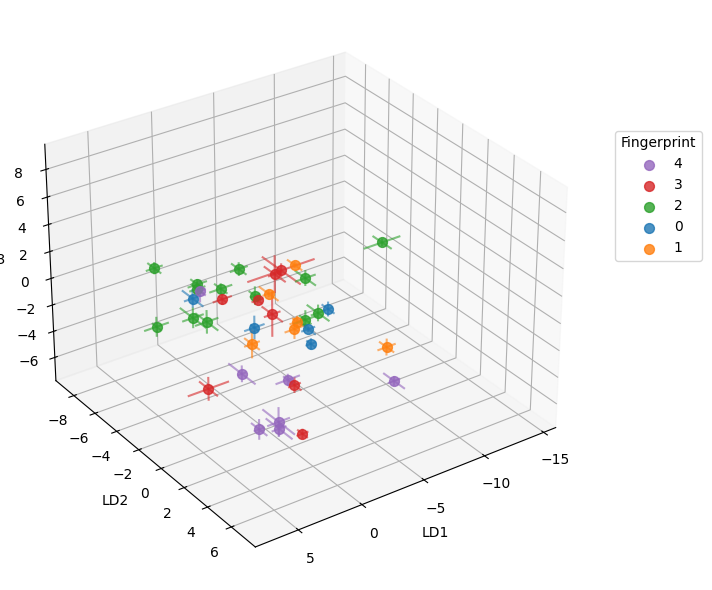

In [31]:
from mpl_toolkits.mplot3d import Axes3D

df_lda = clustered.copy()  # your LDA-projected dataframe
# Group by mouse
grouped = df_lda.groupby(['mouse_name', 'mouse_number', 'lab', 'lab_number', 'mouse_cluster', 'litter_number'])
# Compute mean and std for each mouse
mouse_means = grouped[[0, 1, 2]].mean()
mouse_stds  = grouped[[0, 1, 2]].std()/np.sqrt(4)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('tab10', 10)
seen_labels = set()

for mouse in mouse_means.index:
    mean_vals = mouse_means.loc[mouse].values
    std_vals  = mouse_stds.loc[mouse].values

    x, y, z = mean_vals
    sx, sy, sz = std_vals

    label = str(mouse[4])
    color = colors[mouse[4]]

    # only label once per mouse
    plot_label = label if label not in seen_labels else None
    seen_labels.add(label)

    # point
    ax.scatter(
        x, y, z,
        color=color,
        s=50,
        alpha=0.8,
        label=plot_label
    )

    # error bars
    ax.plot([x - sx, x + sx], [y, y], [z, z], color=color, alpha=0.6)
    ax.plot([x, x], [y - sy, y + sy], [z, z], color=color, alpha=0.6)
    ax.plot([x, x], [y, y], [z - sz, z + sz], color=color, alpha=0.6)

# ax.scatter(archetypes.T[0], archetypes.T[1], archetypes.T[2], color='black', alpha=1)
# # ax.plot(archetypes.T[0], archetypes.T[1], archetypes.T[2], color='black', alpha=1)
# ax.plot(np.concatenate([archetypes.T[0], [archetypes.T[0][0]], [archetypes.T[0][1]]]), 
#         np.concatenate([archetypes.T[1], [archetypes.T[1][0]], [archetypes.T[1][1]]]),
#         np.concatenate([archetypes.T[2], [archetypes.T[2][0]], [archetypes.T[2][1]]]), color='grey')

ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')

ax.legend(
    title='Fingerprint',
    bbox_to_anchor=(1.05, .8),
    loc='upper left'
)

ax.view_init(elev=30, azim=55)
plt.tight_layout()
plt.show()


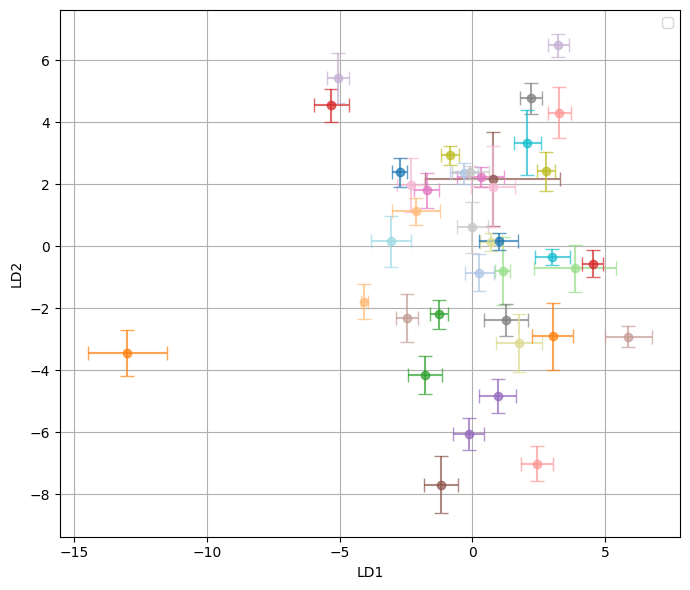

In [33]:
# clustered.groupby(['mouse_name', 'lab', 'lab_number', 'mouse_cluster', 'litter_number'])[np.arange(0, 20, 1)].mean()


# Example: df_lda has columns 'LD1', 'LD2', 'mouse'
df_lda = clustered.copy()  # your LDA-projected dataframe

# Group by mouse
grouped = df_lda.groupby(['mouse_name', 'mouse_number', 'lab', 'lab_number', 'mouse_cluster', 'litter_number'])

# Compute mean and std for each mouse
mouse_means = grouped[[0, 1]].mean()
mouse_stds  = grouped[[0, 1]].std()/np.sqrt(4)

# Plot
plt.figure(figsize=(7,6))
colors = sns.color_palette('tab20', 40)
for mouse in mouse_means.index:
    mean_vals = mouse_means.loc[mouse]
    std_vals = mouse_stds.loc[mouse]
    
    plt.errorbar(
        mean_vals[0], mean_vals[1],
        xerr=std_vals[0], yerr=std_vals[1],
        fmt='o', capsize=5, label=str(mouse[0]), color=colors[mouse[1]], alpha=0.7)  # label=str(mouse[2]),  color=colors[mouse],
# plt.scatter(archetypes.T[0], archetypes.T[1], color='black')
# plt.plot(np.concatenate([archetypes.T[0], [archetypes.T[0][0]]]), np.concatenate([archetypes.T[1], [archetypes.T[1][0]]]), color='grey')
plt.xlabel('LD1')
plt.ylabel('LD2')
# plt.title('Mouse individuality in LDA space')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
# plt.xlim([-10, 8])
# plt.xlim([-10, 8])
plt.legend('')
plt.tight_layout()
plt.show()


NameError: name 'archetypes' is not defined

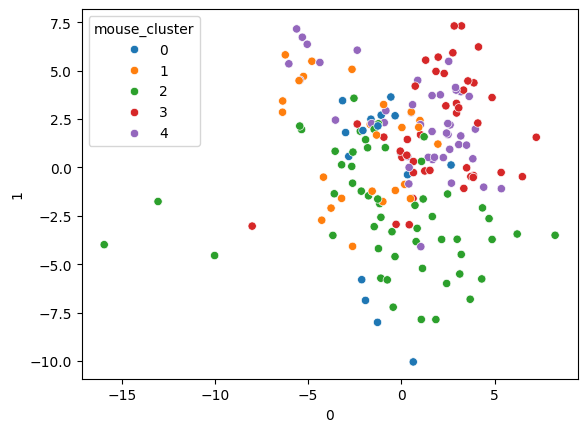

In [34]:
# sns.scatterplot(x=0, y=1, hue='mouse_name', data=clustered, palette='tab20')
# # plt.legend('')
# plt.xlabel('LDA component 1')
# plt.ylabel('LDA component 2')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim([-9, 10.5])
# plt.show()
sns.scatterplot(x=0, y=1, hue='mouse_cluster', data=clustered, palette='tab10')
plt.scatter(archetypes.T[0], archetypes.T[1], color='black', s=1)
plt.plot(np.concatenate([archetypes.T[0], [archetypes.T[0][0]]]), np.concatenate([archetypes.T[1], [archetypes.T[1][0]]]), color='grey')
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
# plt.legend('')
# plt.xlim([-5, 5])


In [35]:
np.sum(lda.explained_variance_ratio_)

np.float64(0.9999999999999999)

Text(0.5, 0, 'LDA components')

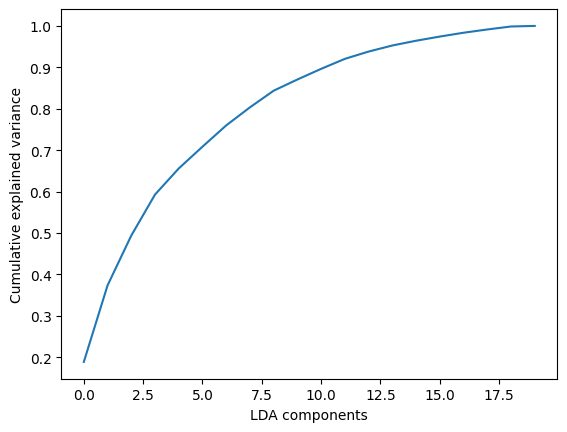

In [36]:
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('LDA components')

# Train/ test mouse correlations

In [37]:
n_per_mouse = 3
lda_components = 20

lda_to_check = 2

final_matrix = np.array(norm_array)
# final_matrix = np.array(mat)

X = final_matrix.copy()
y = pd.factorize(mouse_names)[0]

n_samples = X.shape[0]
mouse_means = np.zeros(len(y)) * np.nan
ld_held_out = np.zeros(len(y)) * np.nan

# Subsample balanced sessions for training in each fold
for test_idx in range(n_samples):
    
    X_test = X[test_idx:test_idx+1]
    y_test = y[test_idx:test_idx+1]

    train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
    X_train_full = X[train_idx]
    y_train_full = y[train_idx]

    # --- balanced subsampling for training ---
    balanced_idx = []
    for m in np.unique(y_train_full):
        m_idx = np.where(y_train_full == m)[0]
        if len(m_idx) >= n_per_mouse:
            balanced_idx.extend(rng.choice(m_idx, n_per_mouse, replace=False))

    balanced_idx = np.array(balanced_idx)
    X_train = X_train_full[balanced_idx]
    y_train = y_train_full[balanced_idx]

    # --- true labels run ---
    lda = LinearDiscriminantAnalysis(
        priors=np.ones(len(np.unique(y_train))) / len(np.unique(y_train)),
        n_components=lda_components)
    
    lda.fit(X_train, y_train)
    transformed = lda.transform(X_train)
    mouse_means[test_idx] = np.mean(transformed[y_train == y_test, lda_to_check])  # LD1
    ld_held_out[test_idx] = lda.transform(X_test)[0][lda_to_check]  # if multiple sessions, take mean

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/

PearsonRResult(statistic=np.float64(0.5947844058784737), pvalue=np.float64(1.4482146479144695e-14))


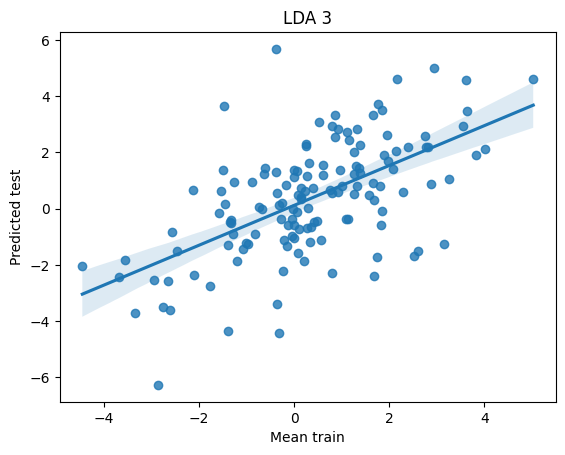

In [38]:
corr_df = pd.DataFrame(columns=['mean_train', 'transformed_test'])
corr_df['mean_train'] = mouse_means
corr_df['transformed_test'] = ld_held_out
corr_df = corr_df.dropna()

sns.regplot(x=np.array(corr_df['mean_train']).astype(float), y=corr_df['transformed_test'].astype(float), ci=95) 
plt.xlabel('Mean train')
plt.ylabel('Predicted test')
plt.title('LDA '+str(lda_to_check+1))

res = stats.pearsonr(np.array(corr_df['mean_train']).astype(float), corr_df['transformed_test'].astype(float))
print(res)

## Correlate with feature probability

In [61]:
del session_syllables, final_matrix, design_df, all_sequences, binarized

In [62]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str)
states_file = states_file[['mouse_name', 'session', 'most_likely_states', 'trial_type', 'trial_id', 'broader_label',
                           'correct', 'reaction', 'response', 'elongation', 'choice', 'avg_wheel_vel', 'whisker_me', 'l_paw_x', 'r_paw_x']]

# Trial modes

In [283]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
trial_clusters = pd.read_parquet(data_path+'17_trial_waterclust')

In [294]:
group_cols = ['mouse_name', 'session']

# Count syllables per group
data = (
    trial_clusters
    .groupby(group_cols + ['trial_cluster'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))
new_clustered = clustered.copy()
new_clustered['session'] = np.array(session_syllables.reset_index()['session'])

joint = data.merge(new_clustered, on=['mouse_name', 'session'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/1091089324.py:5: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



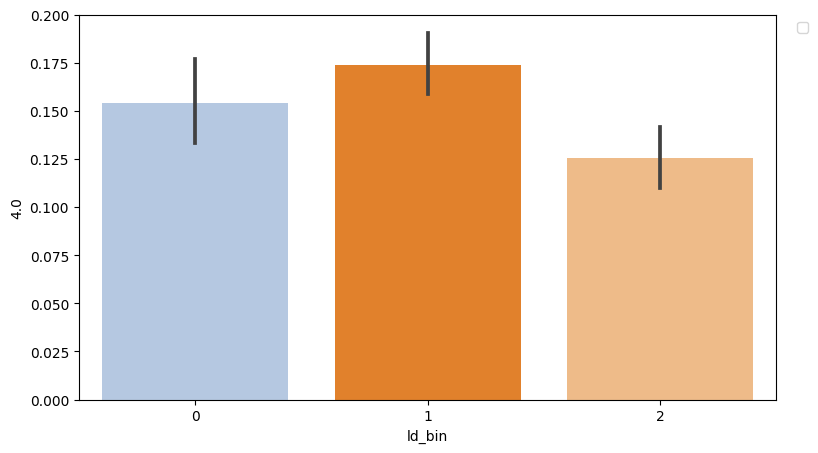

In [308]:
n_bins = 3
joint['ld_bin'] = pd.qcut(joint['LD1'], n_bins, labels=False)
plt.figure(figsize=(9,5))
sns.barplot(y=4, x='ld_bin', data=joint, palette=scatter_colors)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')


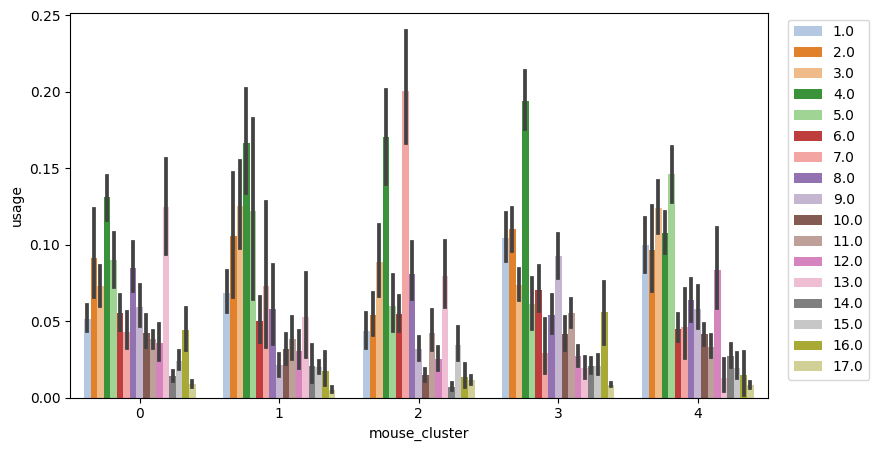

In [296]:
plt.figure(figsize=(9,5))
sns.barplot(hue='trial_cluster', y='usage', x='mouse_cluster', data=joint, palette=scatter_colors)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')


In [297]:
group_cols = ['mouse_name', 'session']

# Count syllables per group
data = (
    trial_clusters
    .groupby(group_cols + ['trial_cluster'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['trial_cluster']).reset_index().fillna(0)

lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])

joint = data.merge(lda_df, on=['session', 'mouse_name'])

In [299]:
ld = 'LD1'
trial_modes = np.arange(1, 18, 1)
# sort by LDA
df_sorted = joint.sort_values(ld)

# bin along LD axis
n_bins = 3
df_sorted['ld_bin'] = pd.qcut(df_sorted[ld], n_bins, labels=False)

# average composition per bin
bin_means = df_sorted.groupby('ld_bin')[trial_modes].mean()


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarn

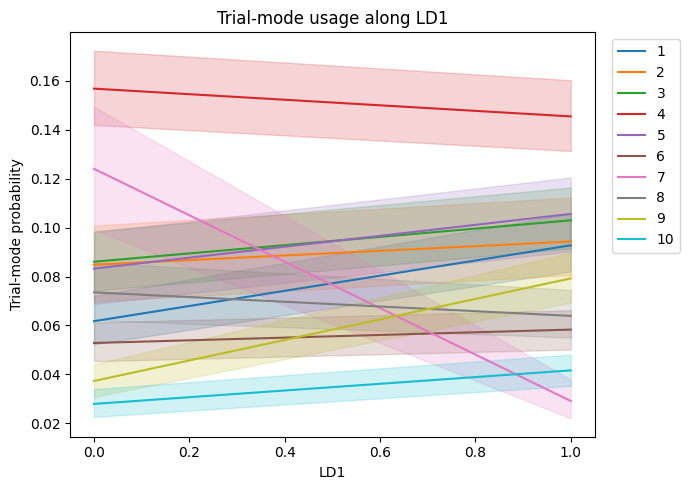

In [291]:
plt.figure(figsize=(7,5))

for col in trial_modes[:10]:
    sns.lineplot(x='ld_bin', y=col, data=df_sorted, label=col)

plt.xlabel('LD1')
plt.ylabel('Trial-mode probability')
plt.title('Trial-mode usage along LD1')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout()
plt.show()
# sns.lineplot(x='ld_bin', y=1, data=df_sorted)

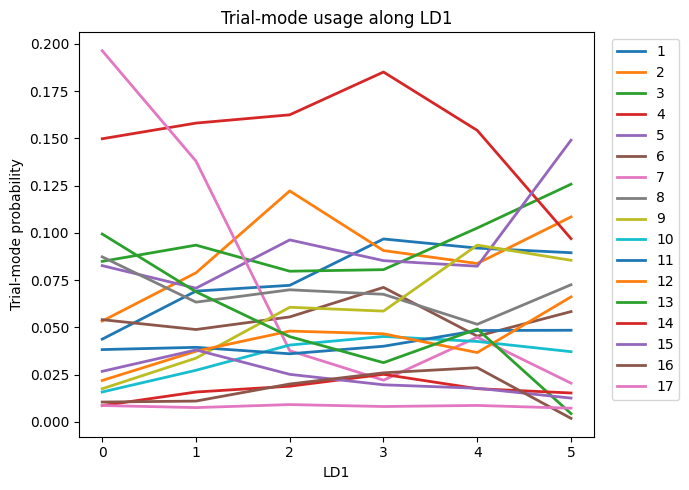

In [249]:
plt.figure(figsize=(7,5))

for col in trial_modes:
    plt.plot(
        np.arange(0, n_bins, 1),
        bin_means[col],
        label=col,
        linewidth=2
    )

plt.xlabel('LD1')
plt.ylabel('Trial-mode probability')
plt.title('Trial-mode usage along LD1')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout()
plt.show()



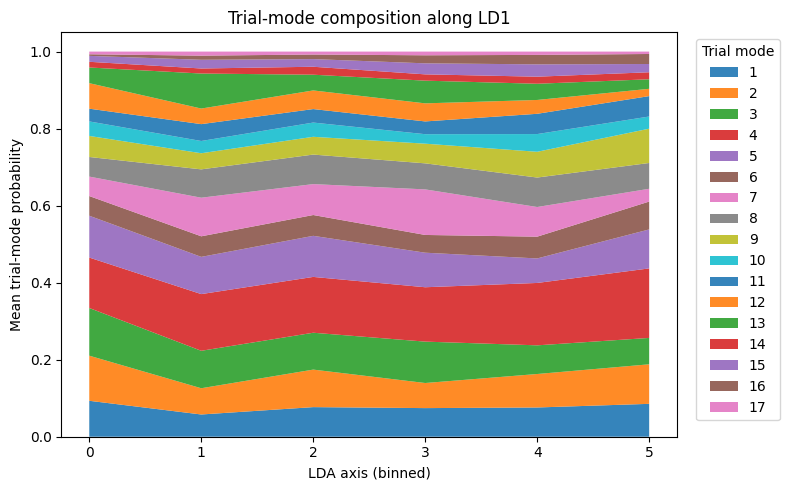

In [240]:
plt.figure(figsize=(8,5))

x = np.arange(len(bin_means))
y = bin_means.T.values  # shape: (n_trials, n_bins)

plt.stackplot(x, y, labels=trial_modes, alpha=0.9)

plt.xlabel('LDA axis (binned)')
plt.ylabel('Mean trial-mode probability')
plt.title('Trial-mode composition along LD1')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
    title='Trial mode')

plt.tight_layout()
plt.show()


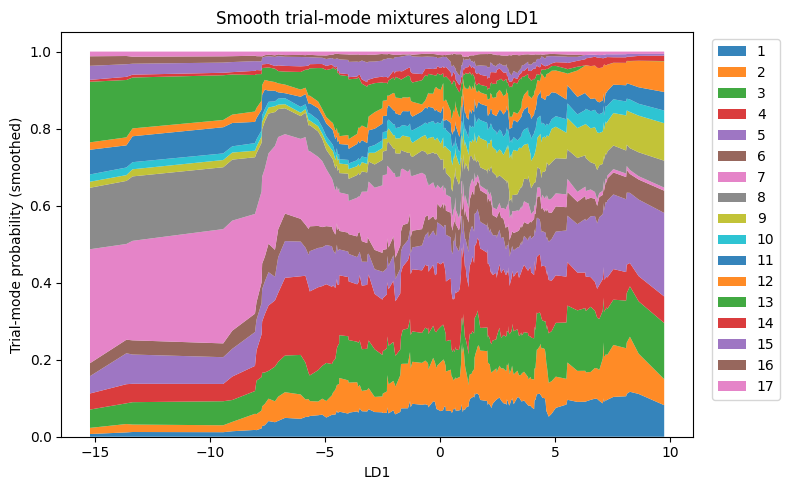

In [ ]:
window = 10  # controls smoothness
df_smooth = df_sorted.copy()
for col in trial_modes:
    df_smooth[col] = df_smooth[col].rolling(
        window, center=True, min_periods=1).mean()
plt.figure(figsize=(8,5))

x = df_smooth[ld].values
y = df_smooth[trial_modes].values.T

plt.stackplot(
    x,
    y,
    labels=trial_modes,
    alpha=0.9)

plt.xlabel('LD1')
plt.ylabel('Trial-mode probability (smoothed)')
plt.title('Smooth trial-mode mixtures along LD1')

plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left')

plt.tight_layout()
plt.show()



/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/2706277304.py:30: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/2706277304.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/2706277304.py:30: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/2706277304.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

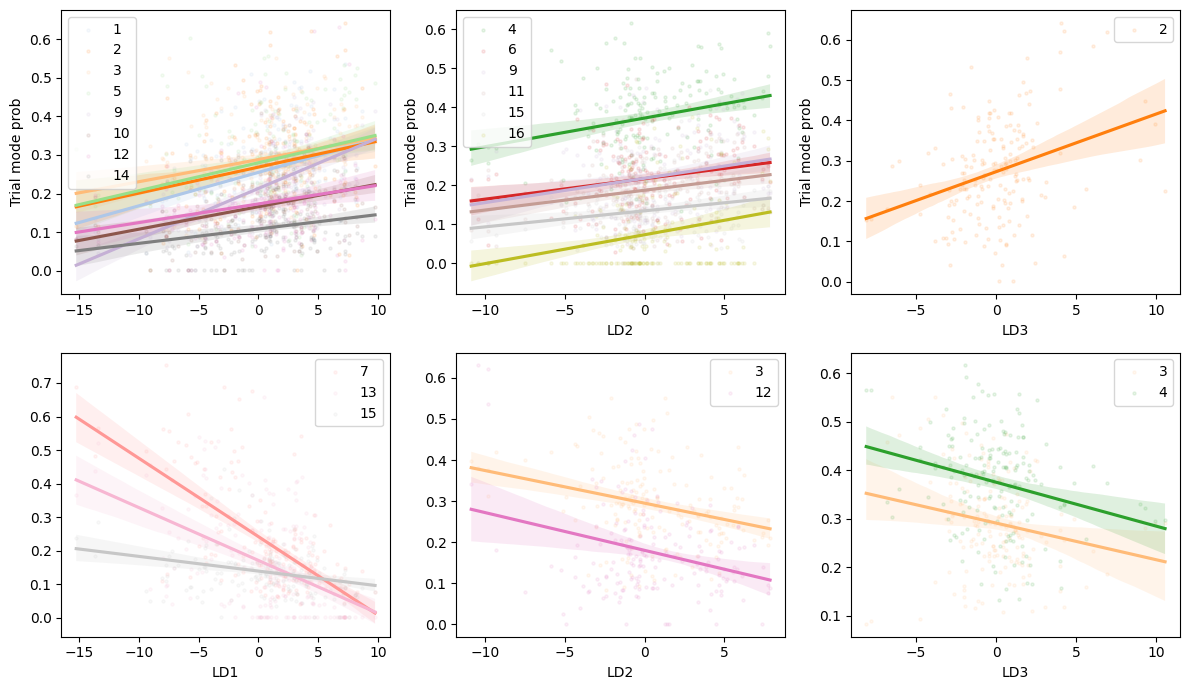

In [221]:
trial_modes = np.arange(1, 18, 1)
cmap = plt.get_cmap("tab20")
clusters = np.unique(trial_modes)
color_dict = {
    k: cmap(k % cmap.N)   # exact tab20 color
    for k in clusters}
scatter_colors = np.array([color_dict[k] for k in trial_modes])

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(12, 7))

for t, trial in enumerate(trial_modes):
    palette = sns.color_palette('Set2', 8)
    for l, ld in enumerate(['LD1', 'LD2', 'LD3']):

            ld_data = joint[ld]
            trial_data = np.sqrt(joint[trial]+.000001)
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(trial_data.astype(float)))
            if res[0]>0 and res[1] < 0.01:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(trial_data.astype(float)), 
                            ax=axs[0, l], ci=95, color=color_dict[trial], label=str(trial), 
                            scatter_kws=dict(alpha=0.1, s=5, color=color_dict[trial])) # label=str(np.round(res[1], 3))
            elif res[0]<0 and res[1] < 0.01:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(trial_data.astype(float)), 
                            ax=axs[1, l], ci=95, color=color_dict[trial], label=str(trial), 
                            scatter_kws=dict(alpha=0.1, s=5, color=color_dict[trial]))
            axs[0, l].set_xlabel(ld)
            axs[1, l].set_xlabel(ld)
            axs[0, l].set_ylabel('Trial mode prob')
            axs[0, l].legend()
            axs[1, l].legend()
            # axs[1, l].set_title(ld)

    plt.tight_layout()

## Paw states

In [93]:
identifiable_mapping = {'000': 0.0,
        '100': 1.0,
        '200': 2.0,
        '300': 3.0,
        '400': 4.0,
        '500': 5.0,
        '600': 6.0,
        '700': 7.0,
        
        '010': 8.0,
        '110': 9.0,
        '210': 10.0,
        '310': 11.0,
        '410': 12.0,
        '510': 13.0,
        '610': 14.0,
        '710': 15.0,

        '001': 16.0,
        '101': 17.0,
        '201': 18.0,
        '301': 19.0, 
        '401': 20.0, 
        '501': 21.0, 
        '601': 22.0, 
        '701': 23.0, 

        '011': 24.0,
        '111': 25.0,
        '211': 26.0,
        '311': 27.0,
        '411': 28.0,
        '511': 29.0,
        '611': 30.0,
        '711': 31.0,
        'nan': np.nan
        }

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['0', '0', '0', '0', 
          '1', '1', '1', '1',
          '2', '2', '2', '2',
          '3', '3', '3', '3',
          '4', '4', '4', '4',
          '5', '5', '5', '5',
          '6', '6', '6', '6',
          '7', '7', '7', '7']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

In [94]:
states_file['paw_states'] = rename_func(inverted_func(states_file['most_likely_states']))

In [95]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['paw_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['paw_states']).reset_index().fillna(0)

lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])

# lda_df = lda_df.loc[lda_df['LD1']>-15]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/73674196.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/73674196.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/73674196.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23830/73674196.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

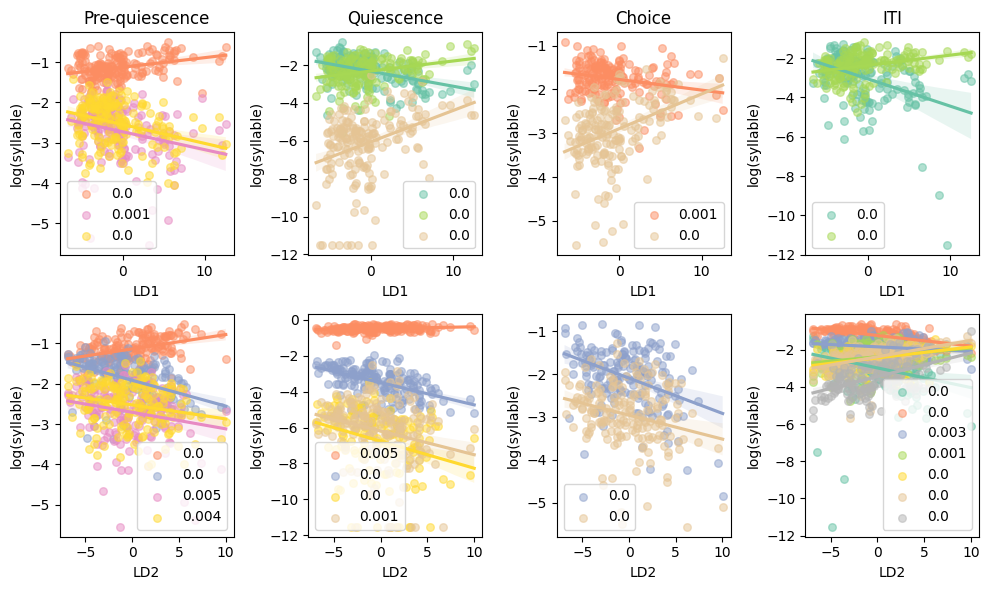

In [96]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set2', 8)
# for l, ld in enumerate(['LD1', 'LD2', 'LD3', 'LD4', 'LD5']):
for l, ld in enumerate(['LD1', 'LD2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['0', '1', '2', '3', '4', '5', '6', '7']):
            paw_data = np.log(epoch_data[paw]+0.00001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.01:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color=palette[p], label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('log(syllable)')
            axs[l, e].legend()
        axs[0, e].set_title(epoch)

plt.tight_layout()

In [100]:
group_cols = ['mouse_name', 'session']
# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['paw_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['paw_states']).reset_index().fillna(0)

lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])

lda_df = lda_df.loc[lda_df['LD1']>-15]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


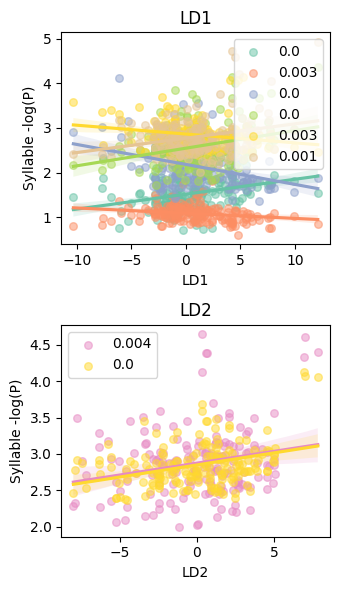

In [105]:
fig, axs = plt.subplots(2, sharex=False, sharey=False, figsize=(3.5, 6))
palette = sns.color_palette('Set2', 8)
# for l, ld in enumerate(['LD1', 'LD2', 'LD3', 'LD4', 'LD5']):
for l, ld in enumerate(['LD1', 'LD2']):
    for p, paw in enumerate(['0', '1', '2', '3', '4', '5', '6', '7']):
        paw_data = -np.log(joint[paw])
        # paw_data = np.sqrt(epoch_data[paw])
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
        if res[1] < 0.01:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                        ax=axs[l], ci=95, color=palette[p], label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
        axs[l].set_xlabel(ld)
        axs[l].set_ylabel('Syllable -log(P)')
        axs[l].legend()
        axs[l].set_title(ld)

plt.tight_layout()

## Lick/whisk states

In [192]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick', 
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)


In [193]:
states_file['whisk_lick'] = rename_func(inverted_func(states_file['most_likely_states']))

In [194]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['whisk_lick'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['whisk_lick']).reset_index().fillna(0)

lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])

lda_df = lda_df.loc[lda_df['LD1']>-15]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/691725429.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/691725429.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/691725429.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/691725429.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called wit

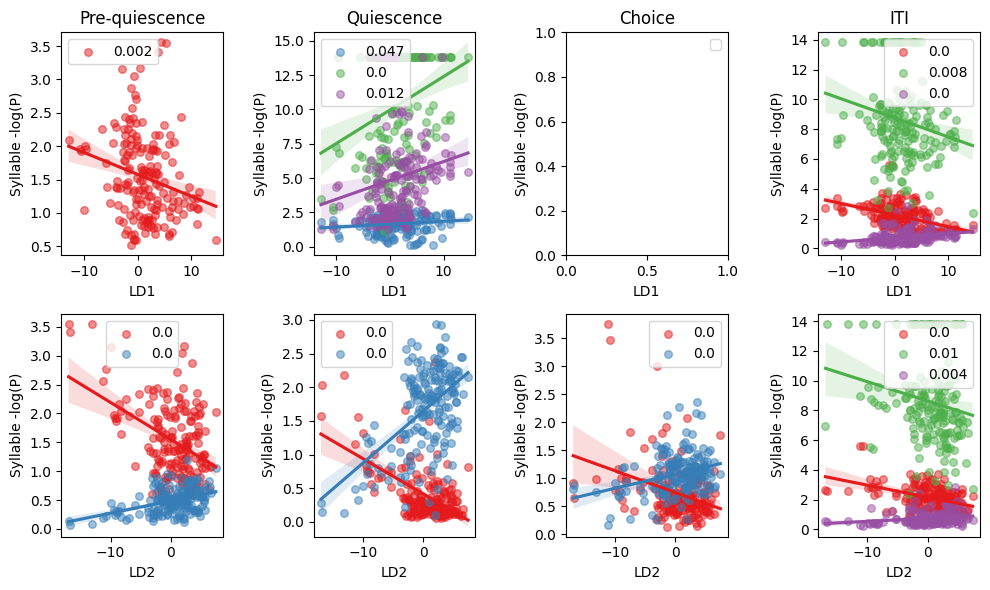

In [196]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick']):
            paw_data = -np.log(epoch_data[paw]+0.000001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color=palette[p], label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
            # if l== 1:
            #     sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
            #                 ax=axs[l, e], ci=95, color=palette[p], label=paw, 
            #                 scatter_kws=dict(alpha=0.5, s=30, color=palette[p]))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('Syllable -log(P)')
            axs[l, e].legend()

        axs[0, e].set_title(epoch)

plt.tight_layout()

In [197]:
group_cols = ['mouse_name', 'session']
# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['whisk'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['whisk']).reset_index().fillna(0)

lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])
lda_df = lda_df.loc[lda_df['LD1']>-15]
joint = data.merge(lda_df, on=['session', 'mouse_name'])

KeyError: 'whisk'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


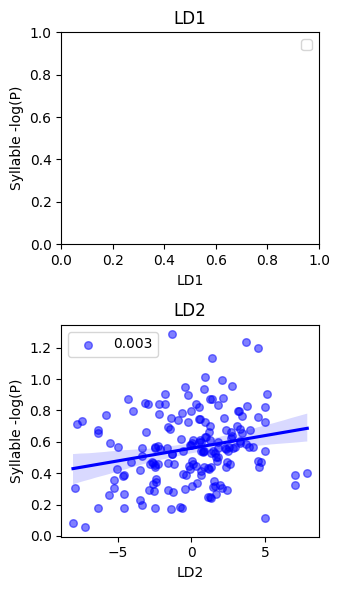

In [ ]:
fig, axs = plt.subplots(2, sharex=False, sharey=False, figsize=(3.5, 6))
palette = sns.color_palette('Set2', 8)
for l, ld in enumerate(['LD1', 'LD2']):
    for p, paw in enumerate(['Whisk']):
        paw_data = -np.log(joint[paw]+0.000001)
        # paw_data = np.sqrt(epoch_data[paw])
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
        if res[1] < 0.01:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                        ax=axs[l], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color='blue'))
        axs[l].set_xlabel(ld)
        axs[l].set_ylabel('Syllable -log(P)')
        axs[l].legend()
        axs[l].set_title(ld)

group_cols = ['mouse_name', 'session']
# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['lick'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['lick']).reset_index().fillna(0)

lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])
lda_df = lda_df.loc[lda_df['LD1']>-15]
joint = data.merge(lda_df, on=['session', 'mouse_name'])

for l, ld in enumerate(['LD1', 'LD2']):
    for p, paw in enumerate(['Lick']):
        paw_data = -np.log(joint[paw]+0.000001)
        # paw_data = np.sqrt(epoch_data[paw])
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
        if res[1] < 0.01:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                        ax=axs[l], ci=95, color='red', label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color='red'))
        axs[l].set_xlabel(ld)
        axs[l].set_ylabel('Syllable -log(P)')
        axs[l].legend()
        axs[l].set_title(ld)

plt.tight_layout()

## Lick whisk states

In [213]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No whisk', 'Whisk', 'No whisk', 'Whisk',  
          'No whisk', 'Whisk', 'No whisk', 'Whisk',  
          'No whisk', 'Whisk', 'No whisk', 'Whisk',    
          'No whisk', 'Whisk', 'No whisk', 'Whisk',    
          'No whisk', 'Whisk', 'No whisk', 'Whisk',   
          'No whisk', 'Whisk', 'No whisk', 'Whisk',    
          'No whisk', 'Whisk', 'No whisk', 'Whisk',  
          'No whisk', 'Whisk', 'No whisk', 'Whisk',  ]

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)


In [214]:
states_file['whisk'] = rename_func(inverted_func(states_file['most_likely_states']))

In [215]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No lick', 'No lick', 'Lick', 'Lick',
          'No lick', 'No lick', 'Lick', 'Lick',
          'No lick', 'No lick', 'Lick', 'Lick',   
          'No lick', 'No lick', 'Lick', 'Lick',   
          'No lick', 'No lick', 'Lick', 'Lick',  
          'No lick', 'No lick', 'Lick', 'Lick',    
          'No lick', 'No lick', 'Lick', 'Lick',  
          'No lick', 'No lick', 'Lick', 'Lick',]

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_lick = np.vectorize(rename_labels.get)
states_file['lick'] = rename_lick(inverted_func(states_file['most_likely_states']))

In [216]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['whisk'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['whisk']).reset_index().fillna(0)

In [217]:
lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])

lda_df = lda_df.loc[lda_df['LD1']>-15]

joint = data.merge(lda_df, on=['session', 'mouse_name'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/1223993205.py:17: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/1223993205.py:57: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



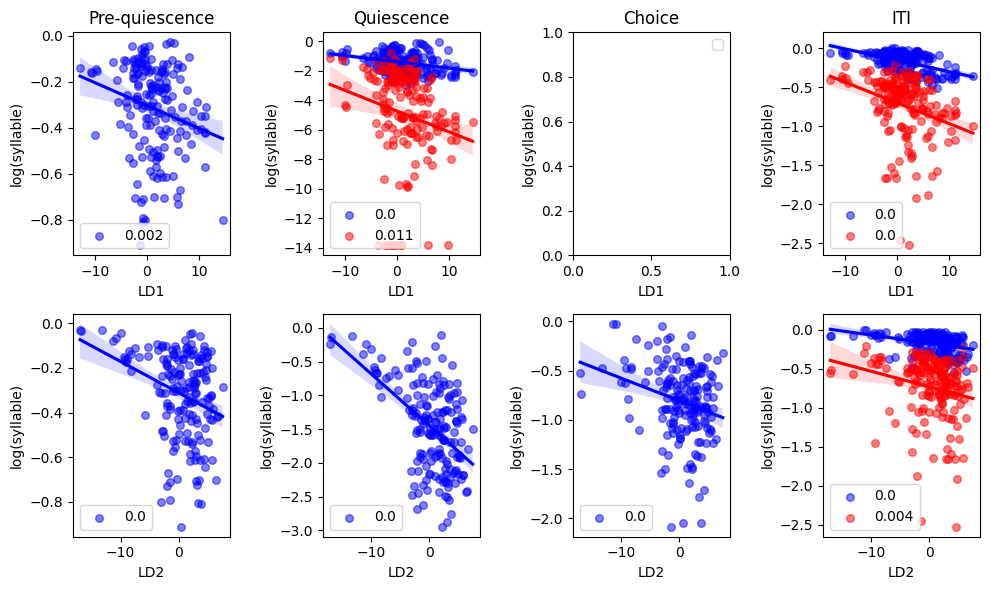

In [218]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['Whisk']):
            paw_data = np.log(epoch_data[paw]+0.000001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color='blue'))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('log(syllable)')
            axs[l, e].legend()

        axs[0, e].set_title(epoch)


group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']
# Count syllables per group
data = (
    states_file
    .groupby(group_cols + ['lick'])
    .size()
    .reset_index(name='count'))
# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))
group_cols = ['mouse_name', 'session', 'broader_label']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['lick']).reset_index().fillna(0)
lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])
lda_df = lda_df.loc[lda_df['LD1']>-15]
joint = data.merge(lda_df, on=['session', 'mouse_name'])

for l, ld in enumerate(['LD1', 'LD2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()
        for p, paw in enumerate(['Lick']):
            paw_data = np.log(epoch_data[paw]+0.000001)
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(paw_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(paw_data.astype(float)), 
                            ax=axs[l, e], ci=95, color='red', label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color='red'))
            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel('log(syllable)')
            axs[l, e].legend()

        axs[0, e].set_title(epoch)
plt.tight_layout()

# Trial-level descriptors

In [226]:
lda_df = clustered.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
lda_df = lda_df[['LD1', 'LD2', 'LD3', 'LD4', 'LD5', 'LD6', 'mouse_name', 'lab',
          'lab_number', 'litter_id', 'litter_number', 'mouse_cluster']]
lda_df['session'] = np.array(session_syllables.reset_index()['session'])


lda_df = lda_df.loc[lda_df['LD1']>-15]


joint = data.merge(lda_df, on=['session', 'mouse_name'])

In [227]:
states_file['binary_choice'] = states_file['choice']
states_file.loc[states_file['choice']=='left', 'binary_choice'] = 0.0
states_file.loc[states_file['choice']=='right', 'binary_choice'] = 1.0

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/76687812.py:23: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

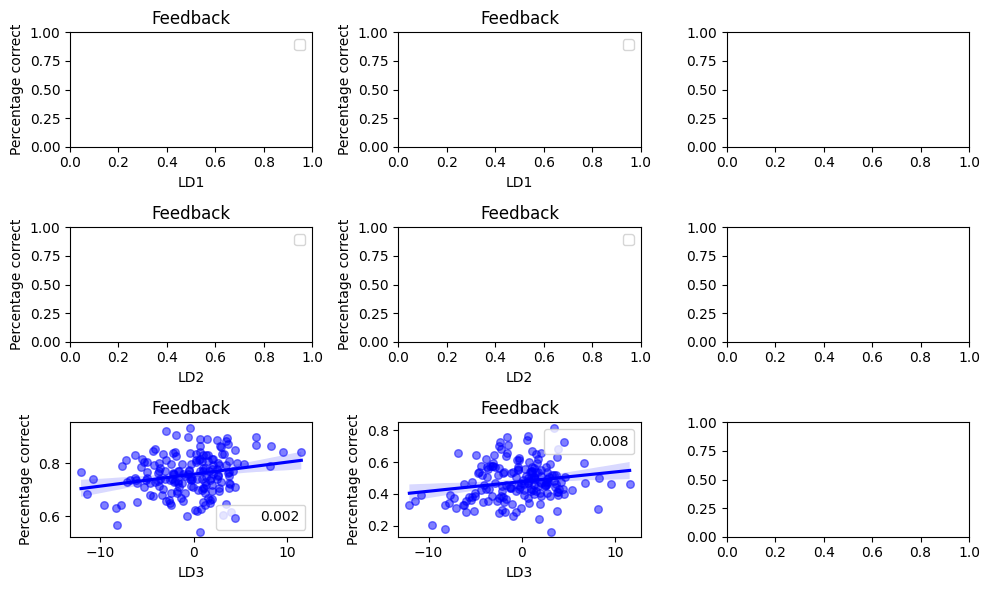

In [280]:
vars_interest = ['correct', 'binary_choice'] #, 'reaction', 'elongation']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2', 'LD3']):
    for v, var in enumerate(vars_interest):
        states_file[var] = states_file[var].astype(float)
        group_cols = ['mouse_name', 'session']
        # Mean per group
        data = (states_file.groupby(group_cols)[var].mean().reset_index())
        joint = data.merge(lda_df, on=['session', 'mouse_name'])
        
        var_data = joint[var]
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
        if res[1] < 0.05:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                        ax=axs[l, v], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color='blue'))

        axs[l, v].set_xlabel(ld)
        axs[l, v].set_ylabel('Percentage correct')
        axs[l, v].legend()
        axs[l, v].set_title('Feedback')

plt.tight_layout()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2375032643.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

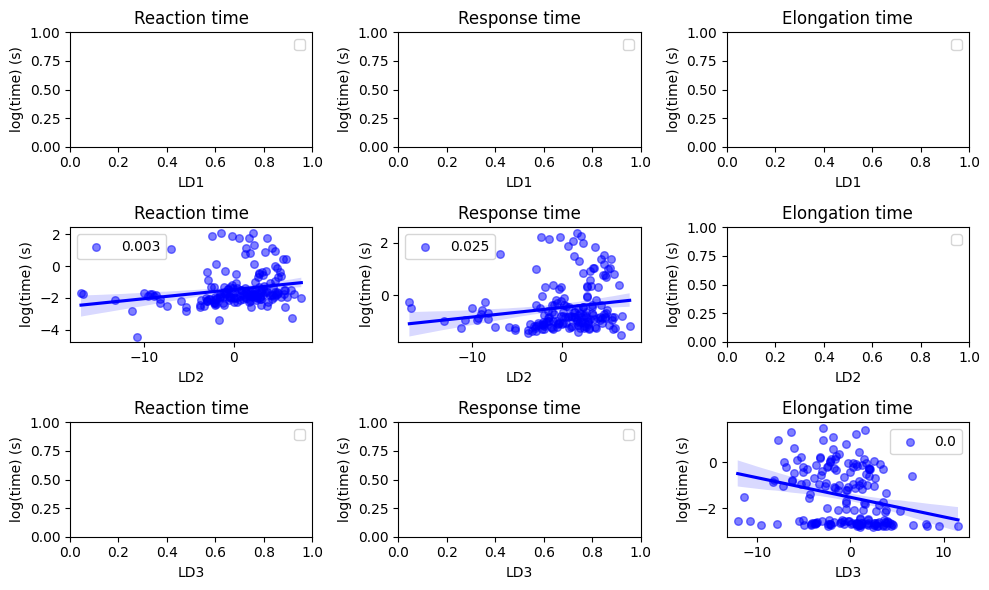

In [229]:
vars_interest = ['reaction', 'response', 'elongation']
titles = ['Reaction time', 'Response time', 'Elongation time']
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2', 'LD3']):
    for v, var in enumerate(vars_interest):
        states_file[var] = states_file[var].astype(float)
        group_cols = ['mouse_name', 'session']
        # Mean per group
        data = (states_file.groupby(group_cols)[var].median().reset_index())
        joint = data.merge(lda_df, on=['session', 'mouse_name'])
        
        var_data = np.log(joint[var])
        # var_data = np.sqrt(joint[var])
        # var_data = joint[var]
        ld_data = joint[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
        if res[1] < 0.05:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                        ax=axs[l, v], ci=95, color='blue', label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color='blue'))

        axs[l, v].set_xlabel(ld)
        axs[l, v].set_ylabel('log(time) (s)')
        axs[l, v].legend()
        axs[l, v].set_title(titles[v])

plt.tight_layout()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_24437/2631811224.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

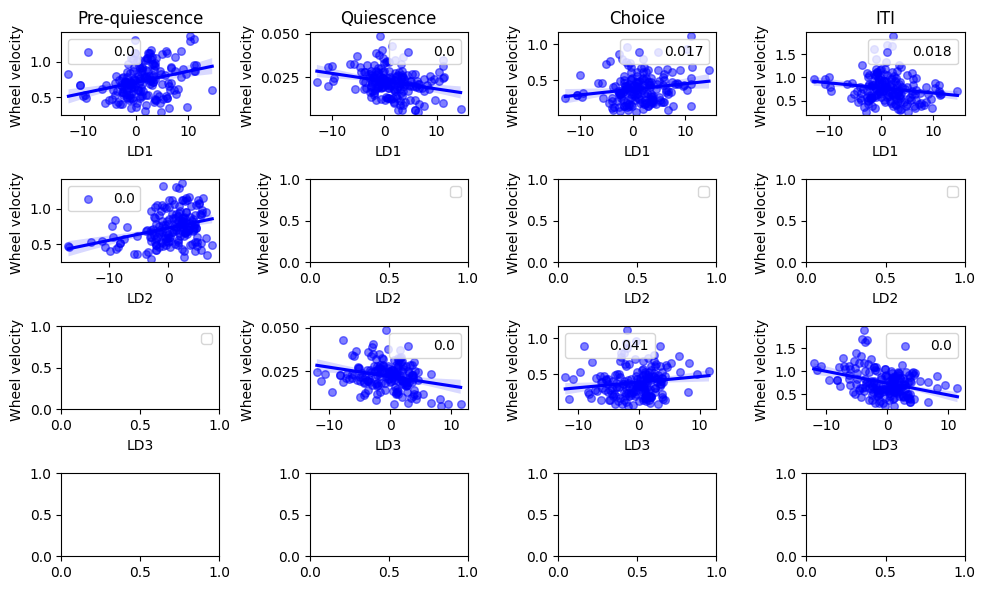

In [ ]:
var = 'abs_wheel_vel'
states_file['abs_wheel_vel'] = np.abs(states_file['avg_wheel_vel'])

fig, axs = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2', 'LD3']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        colors = ['blue', 'red']
        states_file[var] = states_file[var].astype(float)
        group_cols = ['mouse_name', 'session', 'broader_label']
        # Mean per group
        data = (states_file.groupby(group_cols)[var].mean().reset_index())
        joint = data.merge(lda_df, on=['session', 'mouse_name'])

        epoch_data = joint.loc[joint['broader_label']==epoch].dropna()

        var_data = -np.log(epoch_data[var])
        var_data = epoch_data[var]
        # paw_data = np.sqrt(epoch_data[paw])
        ld_data = epoch_data[ld]
        res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
        if res[1] < 0.05:
            sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                        ax=axs[l, e], ci=95, color=colors[0], label=str(np.round(res[1], 3)), 
                        scatter_kws=dict(alpha=0.5, s=30, color=colors[0]))

        axs[l, e].set_xlabel(ld)
        axs[l, e].set_ylabel('Wheel velocity ')
        axs[l, e].legend()

        axs[0, e].set_title(epoch)

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


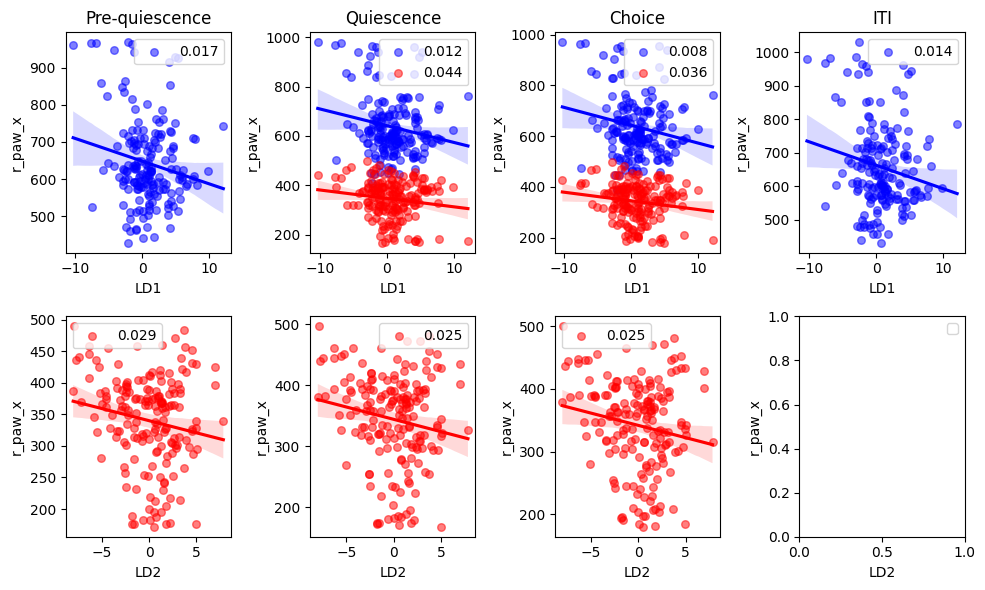

In [ ]:
var = 'abs_wheel_vel'
states_file['abs_wheel_vel'] = np.abs(states_file['avg_wheel_vel'])

fig, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(10, 6))
palette = sns.color_palette('Set1', 4)
for l, ld in enumerate(['LD1', 'LD2']):
    for e, epoch in enumerate(['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']):
        for v, var in enumerate(['l_paw_x', 'r_paw_x']):
            colors = ['blue', 'red']
            states_file[var] = states_file[var].astype(float)
            group_cols = ['mouse_name', 'session', 'broader_label']
            # Mean per group
            data = (states_file.groupby(group_cols)[var].mean().reset_index())
            joint = data.merge(lda_df, on=['session', 'mouse_name'])

            epoch_data = joint.loc[joint['broader_label']==epoch].dropna()

            # var_data = -np.log(epoch_data[var])
            var_data = epoch_data[var]
            # paw_data = np.sqrt(epoch_data[paw])
            ld_data = epoch_data[ld]
            res = stats.pearsonr(np.array(ld_data.astype(float)), np.array(var_data.astype(float)))
            if res[1] < 0.05:
                sns.regplot(x=np.array(ld_data.astype(float)), y=np.array(var_data.astype(float)), 
                            ax=axs[l, e], ci=95, color=colors[v], label=str(np.round(res[1], 3)), 
                            scatter_kws=dict(alpha=0.5, s=30, color=colors[v]))

            axs[l, e].set_xlabel(ld)
            axs[l, e].set_ylabel(var)
            axs[l, e].legend()

            axs[0, e].set_title(epoch)

plt.tight_layout()

# Plot correlations per epoch and state

In [ ]:
use_lda = clustered.copy()
use_lda['session'] = np.array(session_syllables.reset_index()['session'])
use_lda = use_lda.sort_values(by=['session'])


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_26183/2420400624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anacond

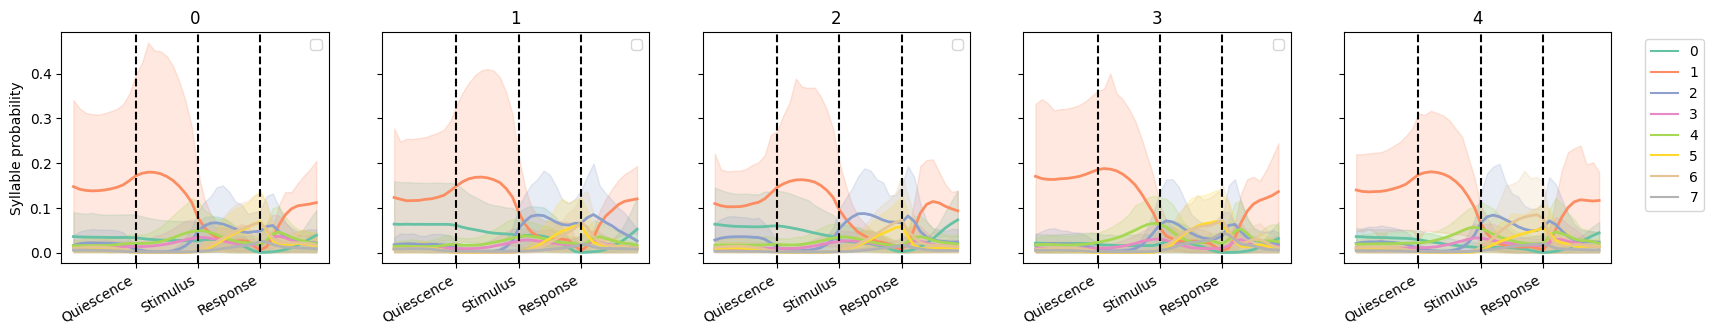

In [ ]:
syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']

palette_7 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set2')
palette_7_list = [palette_7(i) for i in range(palette_7.N)]  # Extract colors properly


fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
    use_data['syllable'] = rename_func(use_data['syllable'])
    use_data = use_data.copy()
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                ax=axs[c], palette='Set2',  linewidth=2)  #  legend=labels[c]  style=var_interest,

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    # axs[c].set_ylim([0, 0.85])
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
    axs[c].set_title(cluster)
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

In [ ]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick',  
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick', 
          'No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

# Syllable corr per timestep

In [168]:
identifiable_mapping = {'000': 0.0,
        '100': 1.0,
        '200': 2.0,
        '300': 3.0,
        '400': 4.0,
        '500': 5.0,
        '600': 6.0,
        '700': 7.0,
        
        '010': 8.0,
        '110': 9.0,
        '210': 10.0,
        '310': 11.0,
        '410': 12.0,
        '510': 13.0,
        '610': 14.0,
        '710': 15.0,

        '001': 16.0,
        '101': 17.0,
        '201': 18.0,
        '301': 19.0, 
        '401': 20.0, 
        '501': 21.0, 
        '601': 22.0, 
        '701': 23.0, 

        '011': 24.0,
        '111': 25.0,
        '211': 26.0,
        '311': 27.0,
        '411': 28.0,
        '511': 29.0,
        '611': 30.0,
        '711': 31.0,
        'nan': np.nan
        }

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)
    
from matplotlib.colors import ListedColormap, to_rgb, to_hex

def create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1'):
    # Pick n_groups distinct colors from base palette
    base_colors = sns.color_palette(base_palette, n_colors=n_groups)
    
    # Function to generate shades for a given color
    def generate_shades(color, n_shades):
        color_rgb = np.array(to_rgb(color))
        # Create shades by interpolating towards white (lighter) or black (darker)
        factors = np.linspace(0.4, 1.0, n_shades)  # You can adjust range for more/less contrast
        return [to_hex(color_rgb * factor + (1 - factor)) for factor in factors]
    
    # Build full palette
    full_palette = []
    for color in base_colors:
        shades = generate_shades(color, shades_per_group)
        full_palette.extend(shades)
    
    return ListedColormap(full_palette)

palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')

identifiable_mapping = {'000': 0.0,
        '100': 4.0,
        '200': 8.0,
        '300': 12.0,
        '400': 16.0,
        '500': 20.0,
        '600': 24.0,
        '700': 28.0,
        
        '010': 1.0,
        '110': 5.0,
        '210': 9.0,
        '310': 13.0,
        '410': 17.0,
        '510': 21.0,
        '610': 25.0,
        '710': 29.0,

        '001': 2.0,
        '101': 6.0,
        '201': 10.0,
        '301': 14.0, 
        '401': 18.0, 
        '501': 22.0, 
        '601': 26.0, 
        '701': 30.0, 

        '011': 3.0,
        '111': 7.0,
        '211': 11.0,
        '311': 15.0,
        '411': 19.0,
        '511': 23.0,
        '611': 27.0,
        '711': 31.0,
        'nan': np.nan
        }

# inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)
identifiable_func = np.vectorize(identifiable_mapping.get)

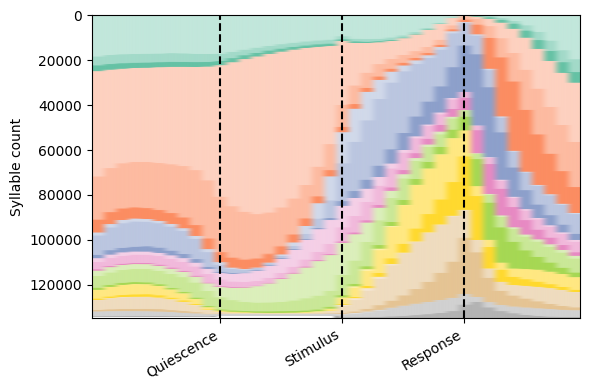

In [169]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(6, 4))

epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

mouse_data = all_sequences.copy()
bound = int(np.shape(mouse_data)[0]/4)
mouse_seq = np.ones((bound, 40)) * np.nan
all_epochs = []
for e, epoch in enumerate(epoch_to_analyse):
    epoch_data = np.vstack(mouse_data.loc[mouse_data['broader_label']==epoch, 'binned_sequence'].values)[:bound, :]
    epoch_data = inverted_func(epoch_data)
    # epoch_data = rename_func(epoch_data)
    epoch_data = identifiable_func(epoch_data)
    mouse_seq[:np.shape(epoch_data)[0], 10*e:10*e+10] = epoch_data[:np.shape(epoch_data)[0], :]
    # if e == 0:
    #     all_epochs = epoch_data[:bound-10, :]
    # else:
    #     all_epochs = np.concatenate([all_epochs, epoch_data[:bound-10, :]], axis=1)
# sorted = all_epochs[np.argsort([ordered_dict[row[0]] for row in all_epochs])]
axs.imshow(np.sort(mouse_seq, axis=0), aspect='auto', cmap=palette_16, interpolation=None, alpha=1)
axs.axvline(x=10, color='k', linestyle='--')
axs.axvline(x=20, color='k', linestyle='--')
axs.axvline(x=30, color='k', linestyle='--')
axs.set_ylabel('Syllable count')
axs.set_xlabel('')
axs.set_title('')
axs.set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
plt.tight_layout()
# axs[m].set_yticks('')
# plt.show()

## Per syllable x epoch 
- no trial type
- for clustering of mice

In [219]:
n_ld = 6
n_syllables = 32*4


In [237]:
group_cols = ['mouse_name', 'session', 'broader_label']
# group_cols = ['mouse_name', 'broader_label']

# Count syllables per group
data = (
    syllable_df
    .groupby(group_cols + ['most_likely_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session']
# group_cols = ['mouse_name']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states', 'broader_label']).reset_index().fillna(0)



In [238]:
df = pd.DataFrame(np.array(data.drop(columns=['mouse_name', 'session'])))
df['mouse_name'] = data['mouse_name']
df['session'] = data['session']

/tmp/ipykernel_9458/2165378409.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [239]:
df = pd.DataFrame(np.array(data.drop(columns='mouse_name')))
df['mouse_name'] = data['mouse_name']

avg_lda = clustered.groupby(['mouse_name', 'lab', 'lab_number', 'litter_id', 'litter_number', 'mouse_cluster'])[np.arange(0, n_ld, 1)].mean().reset_index()
# avg_lda = avg_lda.rename(columns={0:'LD1', 1:'LD2', 2:'LD3', 3:'LD4', 4:'LD5', 5:'LD6'})
use_mice = avg_lda.mouse_name.unique()
df = df.loc[df['mouse_name'].isin(use_mice)]


/tmp/ipykernel_9458/2358175265.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [240]:
n_ld = 6
C = np.zeros((n_ld, n_syllables))
for k in range(n_ld):
    C[k] = [
        stats.pearsonr(df[s], avg_lda[k])[0]
        for s in range(n_syllables)
    ]

sns.heatmap(C, center=0, cmap='coolwarm')
plt.ylabel('LDA component')
plt.xlabel('Syllable')


ValueError: `x` and `y` must have the same length along `axis`.

In [234]:
# avg_lda = clustered.groupby(['mouse_name', 'lab', 'lab_number', 'litter_id', 'litter_number', 'mouse_cluster'])[np.arange(0, n_ld, 1)].mean().reset_index()
use_lda = clustered.copy()
use_lda['session'] = np.array(session_syllables.reset_index()['session'])
use_lda = use_lda.sort_values(by=['session'])

use_mice = use_lda.mouse_name.unique()
df = df.loc[df['mouse_name'].isin(use_mice)]
df = df.sort_values(by=['session'])


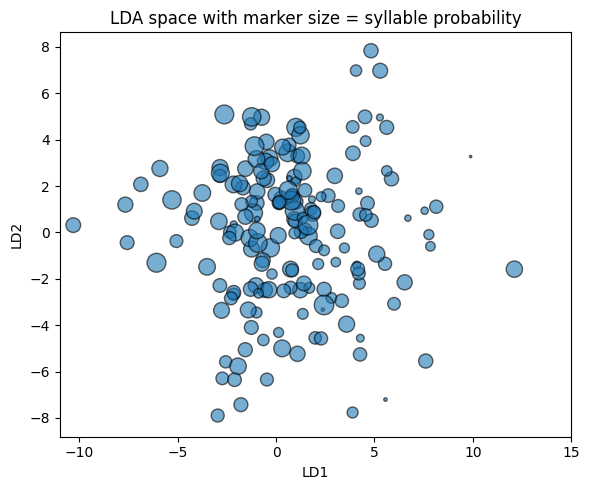

In [223]:

# rescale probabilities → marker sizes
p = np.array(df[0])
sizes = 0 + 200 * (p - p.min()) / (p.max() - p.min())

plt.figure(figsize=(6,5))

plt.scatter(
    use_lda[0],
    use_lda[1],
    s=sizes,
    alpha=0.6,
    edgecolor='k'
)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA space with marker size = syllable probability')
plt.xlim([-11, 15])
plt.tight_layout()
plt.show()


In [114]:
from scipy import stats

IndexError: index 3 is out of bounds for axis 0 with size 3

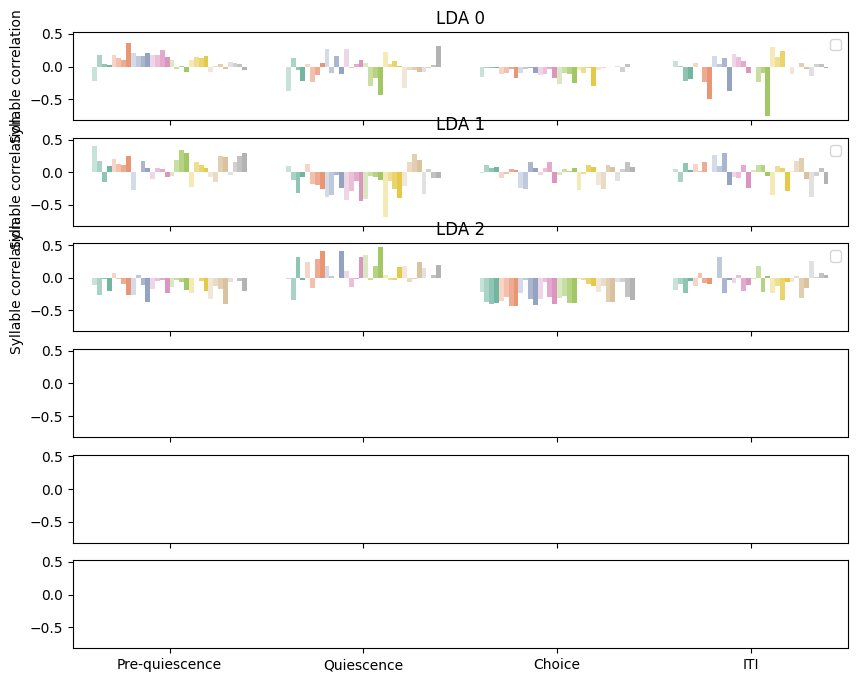

In [212]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set2')

palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly

fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10, 8))

for l in range(6):
    C_df = pd.DataFrame(C[l, :])
    C_df['syllable_name'] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                                '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                                '111', '211', '311', '411', '511',  '611',  '711']*4
    C_df['epoch'] = np.concatenate([np.zeros(32), np.zeros(32)+1, np.zeros(32)+2, np.zeros(32)+3])

    sns.barplot(x='epoch', y=use_lda, hue='syllable_name', data=C_df, palette=palette_16_list, ax=axs[l])
    axs[l].set_ylabel('Syllable correlation')
    axs[l].set_xlabel('')
    axs[l].set_title('LDA '+str(l))
    axs[l].set_xticks([0, 1, 2, 3], ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], rotation=30, ha='right')
    axs[l].legend('')
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 3.5))

plt.tight_layout()

/tmp/ipykernel_9458/3890619626.py:40: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



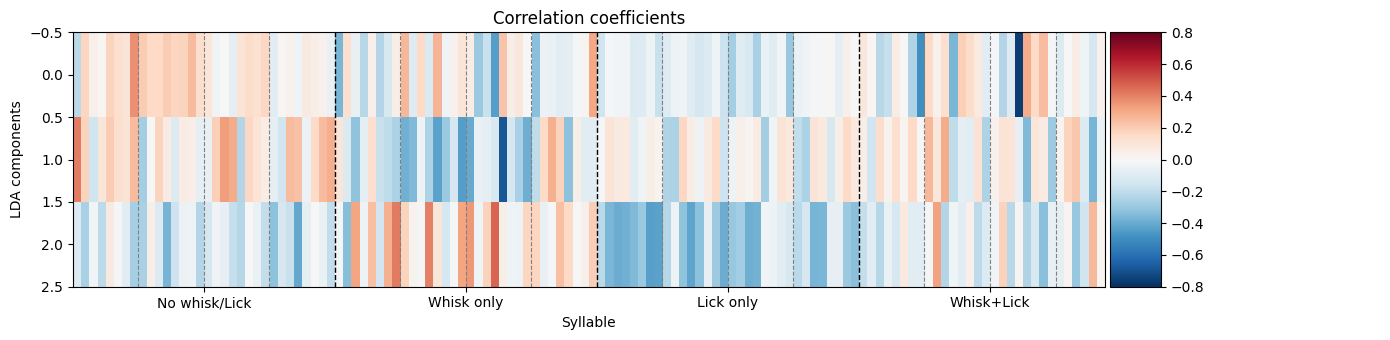

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']
# plot weights for phase and individual identity
fig, ax = plt.subplots()
fig.set_size_inches(14,3.5)

plt_coefs = np.array(C)[:, :-2].astype(float)
plt.imshow(plt_coefs, cmap='RdBu_r', vmin=-.8, vmax=.8, aspect='auto')
plt.title('Correlation coefficients')
ax = plt.gca()
# plt.axhline(np.where(np.diff(mouse_coefs['mouse_cluster'])==1)[0][4] - 0.5+1, c='k', ls='--', lw=1)
plt.axvline(32-0.5, c='k', ls='--', lw=1)
plt.axvline(32*2 - 0.5, c='k', ls='--', lw=1)
plt.axvline(32*3 - 0.5, c='k', ls='--', lw=1)

plt.axvline(8-0.5, c='grey', ls='--', lw=.8)
plt.axvline(8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline(8*3 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline(32+8-0.5, c='grey', ls='--', lw=.8)
plt.axvline(32+8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline(32+8*3 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*2)+8-0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*2)+8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*2)+8*3 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*3)+8-0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*3)+8*2 - 0.5, c='grey', ls='--', lw=.8)
plt.axvline((32*3)+8*3 - 0.5, c='grey', ls='--', lw=.8)
# plt.xlim(-1.5, mouse_coefs.shape[1] - 0.5)
# plt.xticks(np.arange(0, 32*4, 1), syllable_labels*4)
plt.xticks(np.arange(16, 16*8, 32)-0.5, ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick'])

# plt.xticks(np.arange(8, 47, 5), np.arange(0, 39, 5))
# plt.yticks(np.arange(0, len(mouse_coefs), 1), mouse_coefs['mouse_name'])
plt.xlabel('Syllable')
plt.ylabel('LDA components')
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()

In [79]:
mouse_means = avg_lda.merge(df, on='mouse_name')
syllable_cols = np.arange(0, n_syllables, 1)
mouse_corrs = mouse_means[syllable_cols].corrwith(mouse_means[['LD1']])

In [31]:
data = 32*4

most_likely_states     mouse_name                               session  \
broader_label                                                             
0                     CSH_ZAD_019  49e0ab27-827a-4c91-bcaa-97eea27a1b8d   
1                     CSH_ZAD_019  5adab0b7-dfd0-467d-b09d-43cb7ca5d59c   
2                     CSH_ZAD_019  7f6b86f9-879a-4ea2-8531-294a221af5d0   
3                     CSH_ZAD_019  edd22318-216c-44ff-bc24-49ce8be78374   
4                     CSH_ZAD_026  15763234-d21e-491f-a01b-1238eb96d389   
..                            ...                                   ...   
213                 ibl_witten_29  86b6ba67-c1db-4333-add0-f8105ea6e363   
214                 ibl_witten_29  af55d16f-0e31-4073-bdb5-26da54914aa2   
215                 ibl_witten_29  d2832a38-27f6-452d-91d6-af72d794136c   
216                 ibl_witten_29  e9fc0a2d-c69d-44d1-9fa3-314782387cae   
217                 ibl_witten_32  08102cfc-a040-4bcf-b63c-faa0f4914a6f   

most_likely_states       0.0                                           1.0  \
broader_label         Choice       ITI Pre-quiescence Quiescence    Choice   
0                   0.339149  0.120699       0.026358   0.129680  0.140835   
1                   0.369138  0.079765       0.022117   0.094783  0.141354   
2                   0.081512  0.026050       0.010976   0.021330  0.022520   
3                   0.198104  0.119824       0.020911   0.120278  0.168218   
4                   0.568998  0.032781       0.067390   0.162735  0.185915   
..                       ...       ...            ...        ...       ...   
213                 0.305885  0.006750       0.024470   0.194582  0.338245   
214                 0.442594  0.008364       0.110699   0.259749  0.247803   
215                 0.300465  0.031153       0.016331   0.114108  0.185275   
216                 0.597074  0.017285       0.012846   0.179157  0.151445   
217                 0.518088  0.004905       0.032702   0.126036  0.225994   

most_likely_states                                      ...           29.0  \
broader_label            ITI Pre-quiescence Quiescence  ... Pre-quiescence   
0                   0.163326       0.137204   0.501808  ...       0.020407   
1                   0.168883       0.142334   0.436730  ...       0.011516   
2                   0.021784       0.023636   0.053325  ...       0.014904   
3                   0.154162       0.115544   0.457545  ...       0.033567   
4                   0.189763       0.372450   0.592664  ...       0.023625   
..                       ...            ...        ...  ...            ...   
213                 0.020593       0.151875   0.654395  ...       0.009765   
214                 0.014103       0.251933   0.631072  ...       0.014326   
215                 0.047783       0.084557   0.534725  ...       0.007955   
216                 0.039398       0.086084   0.612262  ...       0.001900   
217                 0.047965       0.392077   0.414648  ...       0.000000   

most_likely_states                 30.0                                      \
broader_label      Quiescence    Choice       ITI Pre-quiescence Quiescence   
0                    0.000183  0.028764  0.056517       0.036108   0.000365   
1                    0.000388  0.028339  0.073717       0.024861   0.000000   
2                    0.000739  0.027477  0.048216       0.030018   0.000675   
3                    0.000402  0.030655  0.040884       0.029857   0.000438   
4                    0.000000  0.005424  0.067737       0.026853   0.000000   
..                        ...       ...       ...            ...        ...   
213                  0.000787  0.003801  0.088912       0.006433   0.000337   
214                  0.000000  0.000732  0.120891       0.027127   0.000000   
215                  0.000048  0.007207  0.017668       0.002862   0.000000   
216                  0.000000  0.002417  0.056607       0.006616   0.000000   
217                  0.000000  0.001263  0.043